In [1]:
!pip install yfinance hmmlearn pandas numpy matplotlib seaborn --quiet

DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ------------------------------
# Download historical data
# ------------------------------
ticker = "AAPL"   # change to ^GSPC, TSLA, etc.
start_date = "2013-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# Download daily price data from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date)
df.info()
df.head()


C:\Users\CHINMAYEE\AppData\Local\Temp\ipykernel_24556\3648445174.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3214 entries, 2013-01-02 to 2025-10-10
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3214 non-null   float64
 1   (High, AAPL)    3214 non-null   float64
 2   (Low, AAPL)     3214 non-null   float64
 3   (Open, AAPL)    3214 non-null   float64
 4   (Volume, AAPL)  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2013-01-02,16.628315,16.809127,16.404195,16.773389,560518000
2013-01-03,16.418427,16.647697,16.385111,16.593484,352965200
2013-01-04,15.961099,16.313334,15.925663,16.263057,594333600
2013-01-07,15.867208,16.030756,15.603714,15.809663,484156400
2013-01-08,15.909910,16.109197,15.786947,16.028029,458707200


In [7]:
# Flatten the multi-level columns
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# OR if you know ticker is always 'AAPL', you can do:
# df.columns = df.columns.droplevel(1)

# Check result
print(df.head())


                Close       High        Low       Open     Volume
Date                                                             
2013-01-02  16.628315  16.809127  16.404195  16.773389  560518000
2013-01-03  16.418427  16.647697  16.385111  16.593484  352965200
2013-01-04  15.961099  16.313334  15.925663  16.263057  594333600
2013-01-07  15.867208  16.030756  15.603714  15.809663  484156400
2013-01-08  15.909910  16.109197  15.786947  16.028029  458707200


In [8]:
import numpy as np
import pandas as pd

# Rename Close column
df = df.rename(columns={"Close": "adj_close"})

# Compute daily log returns
df["log_return"] = np.log(df["adj_close"] / df["adj_close"].shift(1))

# Drop the first NA row
df = df.dropna()

# Check the processed data
print(df.head())


            adj_close       High        Low       Open     Volume  log_return
Date                                                                         
2013-01-03  16.418427  16.647697  16.385111  16.593484  352965200   -0.012703
2013-01-04  15.961099  16.313334  15.925663  16.263057  594333600   -0.028250
2013-01-07  15.867208  16.030756  15.603714  15.809663  484156400   -0.005900
2013-01-08  15.909910  16.109197  15.786947  16.028029  458707200    0.002688
2013-01-09  15.661254  15.900821  15.627635  15.824801  407604400   -0.015752


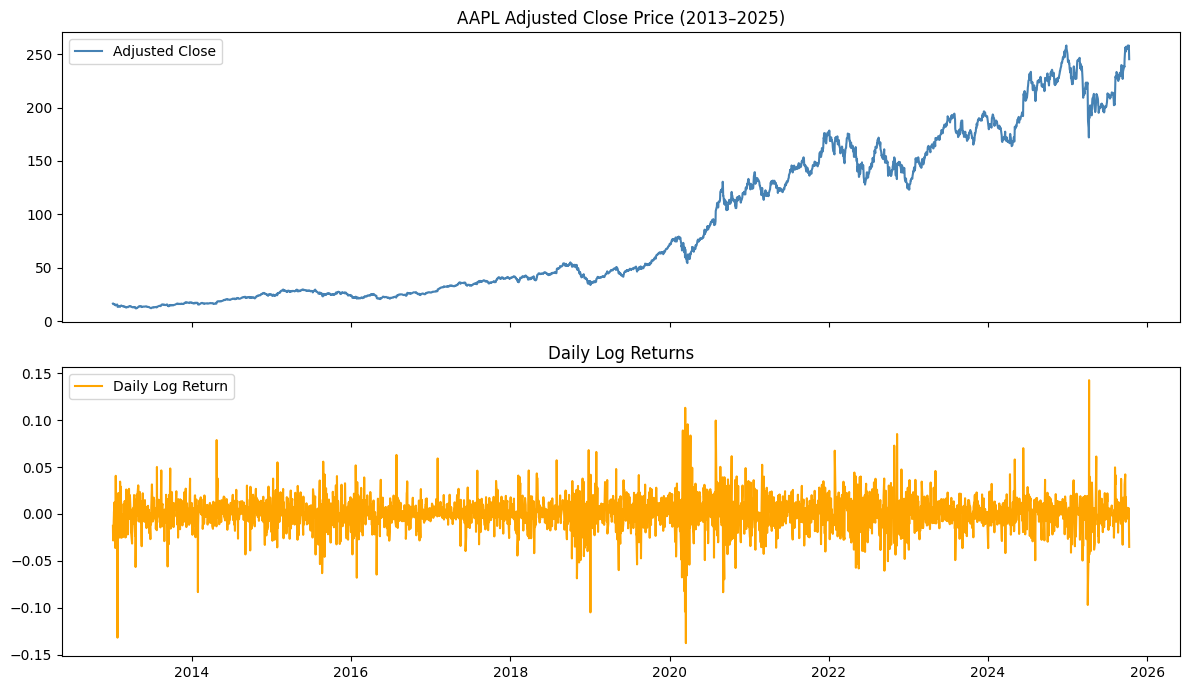

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12,7), sharex=True)
ax[0].plot(df.index, df["adj_close"], label="Adjusted Close", color="steelblue")
ax[0].set_title("AAPL Adjusted Close Price (2013–2025)")
ax[0].legend()

ax[1].plot(df.index, df["log_return"], label="Daily Log Return", color="orange")
ax[1].set_title("Daily Log Returns")
ax[1].legend()

plt.tight_layout()
plt.show()


In [10]:
from hmmlearn import hmm

# Reshape the returns for HMM
X = df["log_return"].values.reshape(-1, 1)

# Create and fit the HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42)
model.fit(X)

# Predict hidden states
df["state"] = model.predict(X)


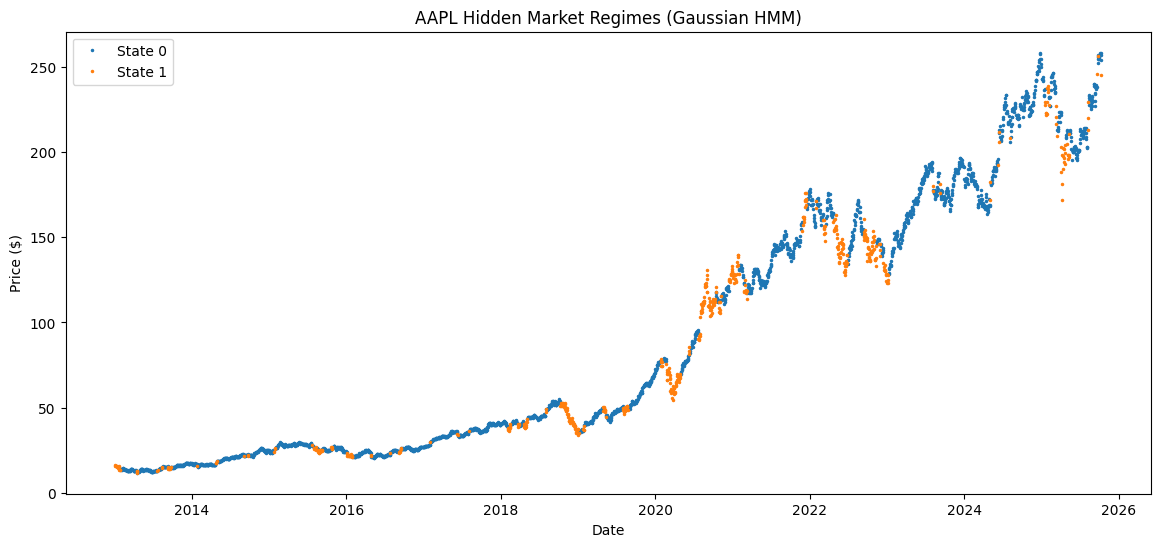

In [11]:
import seaborn as sns
palette = sns.color_palette("tab10", model.n_components)

plt.figure(figsize=(14,6))
for s in range(model.n_components):
    mask = df["state"] == s
    plt.plot(df.index[mask], df["adj_close"][mask], ".", label=f"State {s}", color=palette[s], markersize=3)

plt.title("AAPL Hidden Market Regimes (Gaussian HMM)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()


In [12]:
print("Means of hidden states:")
print(model.means_)

print("\nVariances of hidden states:")
print(np.sqrt(np.array([np.diag(cov) for cov in model.covars_])))

print("\nTransition Matrix:")
print(model.transmat_)


Means of hidden states:
[[ 0.00141743]
 [-0.00121986]]

Variances of hidden states:
[[0.01199584]
 [0.03125123]]

Transition Matrix:
[[0.95497607 0.04502393]
 [0.16032273 0.83967727]]
